# Installation

In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 15.6 MB/s 
     |████████████████████████████████| 431 kB 55.1 MB/s 
     |████████████████████████████████| 163 kB 68.5 MB/s 
     |████████████████████████████████| 6.6 MB 61.6 MB/s 
     |████████████████████████████████| 212 kB 50.4 MB/s 
     |████████████████████████████████| 115 kB 58.9 MB/s 
     |████████████████████████████████| 127 kB 72.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Imports

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)

In [ ]:
BATCH_SIZE=8

# Data Preparation for Bert Model

In [ ]:
dataset_id='imdb'
dataset = load_dataset(dataset_id)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

## Bert Model

In [ ]:
model_id="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

In [ ]:
tokenizer.is_fast

True

In [ ]:
test_input_1='The Weather of Today is Gréat! zwp'
test_input_2='How are you doing?'
inputs=[test_input_1,test_input_2]

tokenizer.tokenize(inputs,)

['the',
 'weather',
 'of',
 'today',
 'is',
 'great',
 '!',
 'z',
 '##w',
 '##p',
 'how',
 'are',
 'you',
 'doing',
 '?']

In [ ]:
output=tokenizer(inputs,padding=True,truncation=True,max_length=128)
print(output)

{'input_ids': [[101, 1996, 4633, 1997, 2651, 2003, 2307, 999, 1062, 2860, 2361, 102], [101, 2129, 2024, 2017, 2725, 1029, 102, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]}


In [ ]:
tokenizer.decode(output['input_ids'][0])

'[CLS] the weather of today is great! zwp [SEP]'

In [ ]:
tokenizer.decode(output['input_ids'][1])

'[CLS] how are you doing? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
def preprocess_function(examples):
  return tokenizer(examples["text"],padding=True,truncation=True,)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
#tokenized_dataset['train'][0]

In [ ]:
#data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True, 
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

In [ ]:
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True, 
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

In [ ]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'token_type_ids':dataset['token_type_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['label']

In [ ]:
tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset=tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [ ]:
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[ 101, 2023, 2038, ...,    0,    0,    0],
       [ 101, 1997, 1996, ...,    0,    0,    0],
       [ 101, 1045, 2293, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 1005, ...,    0,    0,    0],
       [ 101, 1012, 1012, ...,    0,    0,    0],
       [ 101, 2026, 2643, ...,    0,    0,    0]])>, 'token_type_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, numpy=array([1, 1, 1, 1, 0, 1, 0, 0])>

In [ ]:
tf_val_dataset

<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Data Preparation for Roberta Model

In [ ]:
model_id="roberta-base"
tokenizer=RobertaTokenizerFast.from_pretrained(model_id)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
  return tokenizer(examples["text"],padding=True,truncation=True,)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function,)# batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [ ]:
tokenized_dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids','attention_mask', 'label'],
    shuffle=True, 
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

In [ ]:
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids','attention_mask', 'label'],
    shuffle=True, 
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

In [ ]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['label']

In [ ]:
tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset=tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [ ]:
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[    0,   133,  1569, ...,     1,     1,     1],
       [    0,   100,    21, ...,     1,     1,     1],
       [    0,   713, 22154, ...,     1,     1,     1],
       ...,
       [    0, 15852,    57, ...,     1,     1,     1],
       [    0,   133,   527, ...,     1,     1,     1],
       [    0,   100,   794, ...,     1,     1,     1]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 1, 1, 1, 0, 0, 1, 1])>)


# Modeling

## Based on TFBertForSequenceClassification

In [ ]:
model=TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
model.summary()

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


## Based on TFBertModel

In [ ]:
model=TFBertModel.from_pretrained("bert-base-uncased")
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_ids=Input(shape = (512,),dtype=tf.int64,name='input_ids')
token_type_ids=Input(shape = (512,),dtype=tf.int64,name='token_type_ids')
attention_mask=Input(shape = (512,),dtype=tf.int64,name='attention_mask')

x = model([input_ids,token_type_ids,attention_mask])
print(x)
x=Dense(128,activation='relu')(x[0][:,0,:])
output=Dense(1,activation='sigmoid',name='label')(x)

custom_bert = tf.keras.Model(inputs=[input_ids,token_type_ids,attention_mask], outputs=output)

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 512, 768) dtype=float32 (created by layer 'tf_bert_model')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)


In [ ]:
custom_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'token_type_ids[0][0]',     

## Based on TFRobertaForSequenceClassification

In [ ]:
model=TFRobertaForSequenceClassification.from_pretrained(model_id,num_labels=2)
model.summary()

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592130    
 ficationHead)                                                   
                                                                 
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
num_epochs = 3
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [ ]:
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
model.compile(#loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)
    #run_eagerly=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
history=model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=3,)

Epoch 1/3
3125/3125 [==============================] - 619s 191ms/step - loss: 0.2029 - accuracy: 0.9223 - val_loss: 0.1786 - val_accuracy: 0.9300
Epoch 2/3
3125/3125 [==============================] - 594s 190ms/step - loss: 0.1028 - accuracy: 0.9658 - val_loss: 0.1297 - val_accuracy: 0.9536
Epoch 3/3
3125/3125 [==============================] - 594s 190ms/step - loss: 0.0478 - accuracy: 0.9853 - val_loss: 0.1529 - val_accuracy: 0.9554


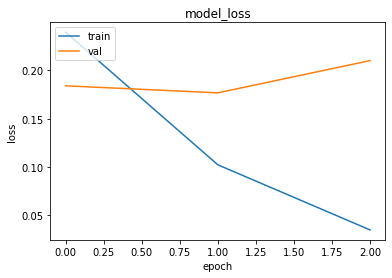

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

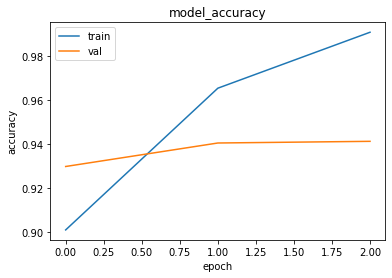

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing


In [ ]:
inputs = tokenizer(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                    "very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so over "], padding=True,return_tensors="tf")

logits = model(**inputs).logits
print(logits)

tf.Tensor(
[[-2.2396984  1.9407922]
 [ 3.3462846 -3.3634923]], shape=(2, 2), dtype=float32)
